In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

In [19]:
def preprocess_data_with_target(df, target):
    """
    Preprocess dataset with target variable:
      - Handles missing values
      - Encodes categorical features
      - Standardizes numerical features
      - Separates features (X) and target (y)
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to preprocess.
    target : str
        The name of the target column.

    Returns
    -------
    X : pandas.DataFrame
        Processed feature matrix
    y : pandas.Series
        Encoded target column
    encoders : dict
        LabelEncoders used for categorical columns
    scaler : StandardScaler
        Scaler fitted on numeric columns
    """

    print(f"First 5 Rows of Data before transformation: \n{df.head()}\n********************* \n")

    # Handle Missing Values
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # numeric
            df[col] = df[col].fillna(df[col].mean())
        else:  # categorical
            df[col] = df[col].fillna(df[col].mode()[0])

    # Separate Features and Target
    X = df.drop(columns=[target])
    y = df[target]

    # Encode Categorical Columns
    encoders = {}
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        encoders[col] = le

    # Encode target if categorical
    if y.dtype == 'object' or str(y.dtype) == 'category':
        le_target = LabelEncoder()
        y = le_target.fit_transform(y)
        encoders[target] = le_target

    # Standardize Numerical Features
    scaler = StandardScaler()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    print(f"\n********************* \nFirst 5 Rows of X after transformation: \n{X.head()}\n*********************")
    print(f"First 5 Rows of y after transformation: \n{y[:5]}\n********************* \n")

    return X, y, encoders, scaler


In [20]:
# Load project_adult.csv as pa
pa = pd.read_csv("project_adult.csv")

# Apply preprocess function on pa
pa_X, pa_y, pa_encoders, pa_scaler = preprocess_data_with_target(df = pa, target = "income")

First 5 Rows of Data before transformation: 
   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0        5514   33         Local-gov  198183     Bachelors             13   
1       19777   36           Private   86459     Assoc-voc             11   
2       10781   58  Self-emp-not-inc  203039           9th              5   
3       32240   21           Private  180190     Assoc-voc             11   
4        9876   27           Private  279872  Some-college             10   

       marital-status       occupation   relationship   race     sex  \
0       Never-married   Prof-specialty  Not-in-family  White  Female   
1  Married-civ-spouse  Exec-managerial        Husband  White    Male   
2           Separated     Craft-repair  Not-in-family  White    Male   
3  Married-civ-spouse  Farming-fishing        Husband  White    Male   
4            Divorced    Other-service  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week native-countr

In [21]:
def preprocess_data_no_target(df):
    """
    Preprocess dataset without a target variable:
      - Handles missing values
      - Encodes categorical features
      - Standardizes numerical features

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to preprocess.

    Returns
    -------
    X : pandas.DataFrame
        Processed feature matrix
    encoders : dict
        LabelEncoders used for categorical columns
    scaler : StandardScaler
        Scaler fitted on numeric columns
    """

    print(f"First 5 Rows of Data before transformation: \n{df.head()}\n********************* \n")

    # ---- Handle Missing Values ----
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # numeric
            df[col] = df[col].fillna(df[col].mean())
        else:  # categorical
            df[col] = df[col].fillna(df[col].mode()[0])

    # ---- Encode Categorical Columns ----
    encoders = {}
    for col in df.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

    # ---- Standardize Numerical Features ----
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    print(f"\n********************* \nFirst 5 Rows of Data after transformation: \n{df.head()}\n*********************")

    return df, encoders, scaler


In [22]:
# Load project_validation_inputs.csv as pv
pv = pd.read_csv("project_validation_inputs.csv")

# Apply preprocess function on pa
pv_X, pv_encoders, pv_scaler = preprocess_data_no_target(df = pv)

First 5 Rows of Data before transformation: 
   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0       14160   27           Private  160178  Some-college             10   
1       27048   45         State-gov   50567       HS-grad              9   
2       28868   29           Private  185908     Bachelors             13   
3        5667   30           Private  190040     Bachelors             13   
4        7827   29  Self-emp-not-inc  189346  Some-college             10   

       marital-status         occupation   relationship   race     sex  \
0            Divorced       Adm-clerical  Not-in-family  White  Female   
1  Married-civ-spouse    Exec-managerial           Wife  White  Female   
2  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
3       Never-married  Machine-op-inspct  Not-in-family  White  Female   
4            Divorced       Craft-repair  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week n

In [23]:
X_train, X_test, y_train, y_test = train_test_split(pa_X, pa_y, test_size=0.3, random_state=42, stratify=pa_y)

In [24]:
class AdalineSGD:
    """
    ADAptive LInear NEuron classifier with Stochastic Gradient Descent.

    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    shuffle : bool (default: True)
        Whether to shuffle training data every epoch.
    random_state : int
        Seed for random weight initialization.

    Attributes
    ----------
    w_ : 1d-array
        Weights after fitting.
    b_ : float
        Bias unit after fitting.
    losses_ : list
        Mean squared error loss at each epoch.
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


/var/folders/ff/rs0n08ks49scy3y95_gm7mvh0000gn/T/ipykernel_32404/1010062689.py:70: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/Users/jmlaurie/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


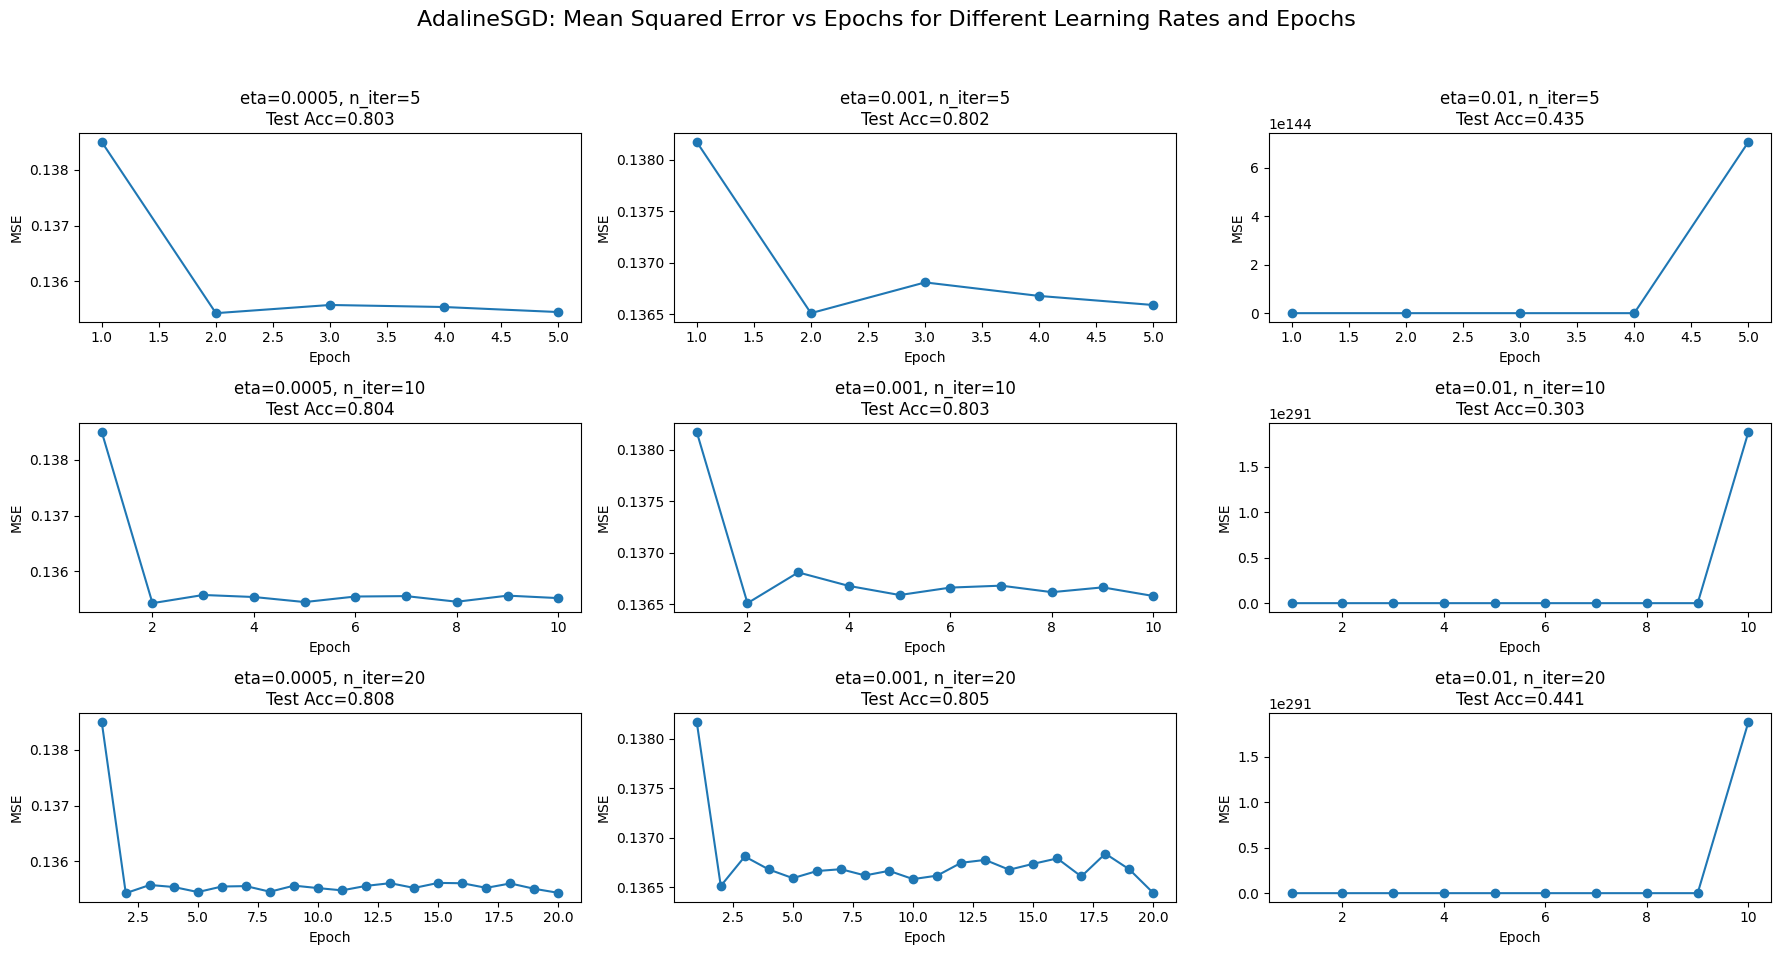

In [25]:
etas = [0.0005, 0.001, 0.01]
n_iters = [5, 10, 20]
results = []
fig, ax = plt.subplots(len(n_iters), len(etas), figsize=(18, 10))
plt.subplots_adjust(hspace=0.4)
best_acc = 0.
best_params = None
best_model = None

for i, n_iter in enumerate(n_iters):
    for j, eta in enumerate(etas):
        model = AdalineSGD(eta=eta, n_iter=n_iter, random_state=1)
        model.fit(X_train.values, y_train)
        y_pred = model.predict(X_test.values)
        acc = accuracy_score(y_test, y_pred)
        # Save metrics
        results.append({
            'eta': eta, 'n_iter': n_iter,
            'accuracy': acc,
            'losses': model.losses_,
            'model': model
        })
        # Track best model
        if acc > best_acc:
            best_acc = acc
            best_params = (eta, n_iter)
            best_model = model
        # Plot
        ax[i, j].plot(range(1, len(model.losses_) + 1), model.losses_, marker='o')
        ax[i, j].set_title(f'eta={eta}, n_iter={n_iter}\nTest Acc={acc:.3f}')
        ax[i, j].set_xlabel('Epoch')
        ax[i, j].set_ylabel('MSE')

plt.suptitle('AdalineSGD: Mean Squared Error vs Epochs for Different Learning Rates and Epochs', size=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


The results in this figure show how the AdalineSGD model’s mean squared error (MSE) evolves over training epochs for various learning rates (eta) and epoch counts (n_iter). For very small learning rates (eta=0.0005, 0.001), MSE drops sharply in the first epoch and then stabilizes, resulting in high classification accuracy (around 0.80). When the learning rate is too high (eta=0.01), however, the MSE diverges after a few epochs, skyrocketing to extreme values (1e144 or greater). This indicates that the model fails to converge and learns poorly, as reflected by much lower accuracy scores (0.44 or below). Increasing the number of epochs slightly improves accuracy for the best learning rates, but only when the learning rate is within a stable regime. This analysis highlights that proper tuning of the learning rate is critical for stable and effective AdalineSGD training, while excessive learning rates lead to extremely poor results and model instability.

In [26]:
print(f"\nBest AdalineSGD Model: eta={best_params[0]}, n_iter={best_params[1]}")
print(f"Test accuracy: {best_acc:.4f}")



Best AdalineSGD Model: eta=0.0005, n_iter=20
Test accuracy: 0.8083


The optimal AdalineSGD model was found using a learning rate of 0.0005 and 20 epochs. This configuration achieved the highest test accuracy of 0.8083 among all settings tested. This suggests that, for this dataset, a very small learning rate combined with a higher epoch count yields the most effective balance between error minimization and generalization performance. Notably, this best-performing model achieves both low MSE during training and robust accuracy on unseen test data, underscoring the importance of carefully selecting hyperparameters for stochastic gradient descent-based classifiers.

In [28]:
validation_preds = best_model.predict(pv_X.values)

# Map predictions back to original income labels if pa_encoders available
target_le = pa_encoders.get("income")
if target_le is not None:
    readable_preds = target_le.inverse_transform(validation_preds)
    output_df = pv.copy()
    output_df['Predicted_Income'] = readable_preds
else:
    output_df = pv.copy()
    output_df['Predicted_Income'] = validation_preds

# save just output labels
output_df[['Predicted_Income']].to_csv("Group_23_Adaline_PredictedOutputs.csv", index=False)
print("Validation predictions saved to Group_23_Adaline_PredictedOutputs.csv")



Validation predictions saved to Group_23_Adaline_PredictedOutputs.csv
